# Empirical Approximation overview

For most models we use sampling MCMC algorithms like Metropolis or NUTS. In pymc3 we got used to store traces of MC samples and then do analysis using them. As new VI interface was implememted it needed a lot of approximation types. 

One of them was so-called *Empirical*. This type of approximation stores particles for SVGD sampler. But there is no difference between independent SVGD particles and MCMC trace. So the idea was pretty simple to understand and realize: make *Empirical* be a bridge between MCMC sampling output and full-fledged VI utils like `apply_replacements` or `sample_node`. For the interface description, see [variational_api_quickstart](http://pymc-devs.github.io/pymc3/notebooks/variational_api_quickstart.html). Here I will just focus on Emprical and give an overview of specific things for *Empirical* approximation

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import theano
import numpy as np
import pymc3 as pm
np.random.seed(42)
pm.set_tt_rng(42)

## Multimodal density
Let's recall the problem from [variational_api_quickstart](http://pymc-devs.github.io/pymc3/notebooks/variational_api_quickstart.html) where we first got a NUTS trace

In [2]:
w = pm.floatX([.2, .8])
mu = pm.floatX([-.3, .5])
sd = pm.floatX([.1, .1])

with pm.Model() as model:
    x = pm.NormalMixture('x', w=w, mu=mu, sd=sd, dtype=theano.config.floatX)
    trace = pm.sample(50000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 4.8131:   1%|          | 2419/200000 [00:00<00:26, 7490.36it/s]
Convergence archived at 2900
Interrupted at 2,900 [1%]: Average Loss = 6.0938
100%|██████████| 50500/50500 [00:24<00:00, 2066.59it/s]


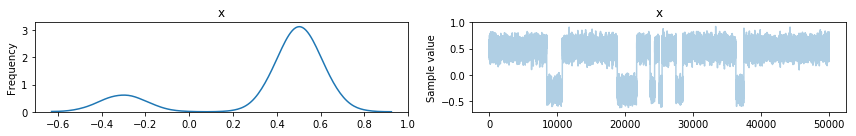

In [3]:
pm.traceplot(trace);

Great. First having a trace we can create `Empirical` approx

In [4]:
print(pm.Empirical.__doc__)

Builds Approximation instance from a given trace,
    it has the same interface as variational approximation

    Parameters
    ----------
    trace : :class:`MultiTrace`
        Trace storing samples (e.g. from step methods)
    local_rv : dict[var->tuple]
        Experimental for Empirical Approximation
        mapping {model_variable -> local_variable (:math:`\mu`, :math:`\rho`)}
        Local Vars are used for Autoencoding Variational Bayes
        See (AEVB; Kingma and Welling, 2014) for details
    scale_cost_to_minibatch : `bool`
        Scale cost to minibatch instead of full dataset, default False
    model : :class:`pymc3.Model`
        PyMC3 model for inference
    random_seed : None or int
        leave None to use package global RandomStream or other
        valid value to create instance specific one

    Examples
    --------
    >>> with model:
    ...     step = NUTS()
    ...     trace = sample(1000, step=step)
    ...     histogram = Empirical(trace[100:])
    


In [5]:
with model:
    approx = pm.Empirical(trace)

In [6]:
approx

This type of approximation has it's own underlying storage for samples that is `theano.shared` itself

In [7]:
approx.histogram

histogram

In [8]:
approx.histogram.get_value()[:10]

array([[ 0.7416169 ],
       [ 0.58335543],
       [ 0.54399127],
       [ 0.62435758],
       [ 0.67444867],
       [ 0.33953333],
       [ 0.6023711 ],
       [ 0.55611253],
       [ 0.4582279 ],
       [ 0.57580113]], dtype=float32)

In [9]:
approx.histogram.get_value().shape

(50000, 1)

It has exactly the same number of samples that you had in trace before. In our particular case it is 50k. Then another thing to notice is thet if you have multitrace with **more than one chain** you'll get much **more samples** stored at once. We flatten all the trace for creating `Empirical`.

This *histogram* is about *how* we store samples. Structure is pretty simple: `(n_samples, n_dim)` The order of these variables is stored internally in the class and in most cases will not be needed for end user

In [10]:
approx._g_order

Sampling from posterior is done uniformly with replacements. Calling `approx.sample(1000)` you'll get again the trace but the order is not determined. There is not way now to reconstruct the underlying trace again with `approx.sample`.

In [11]:
new_trace = approx.sample(50000)

In [12]:
%timeit new_trace = approx.sample(50000)

1.58 s ± 227 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


After sampling function is compiled sampling bacomes really fast

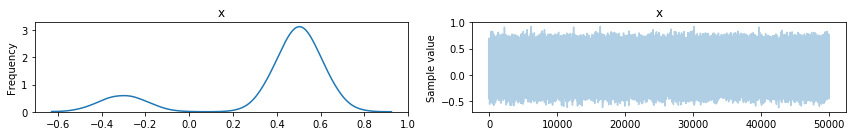

In [13]:
pm.traceplot(new_trace);

You see there is no order any more but reconstructed density is the same.

## 2d density

In [14]:
mu = pm.floatX([0., 0.])
cov = pm.floatX([[1, .5], [.5, 1.]])
with pm.Model() as model:
    pm.MvNormal('x', mu=mu, cov=cov, shape=2)
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 0.21944:   0%|          | 625/200000 [00:00<01:09, 2866.83it/s]
Convergence archived at 800
Interrupted at 800 [0%]: Average Loss = 0.20698
100%|██████████| 1500/1500 [00:03<00:00, 470.55it/s]


In [15]:
with model:
    approx = pm.Empirical(trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e9da358>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11ea76f28>]], dtype=object)

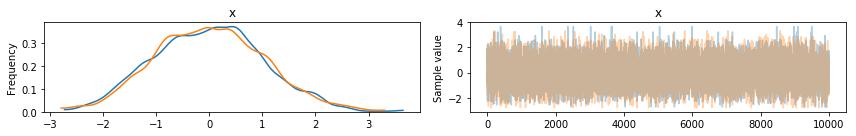

In [16]:
pm.traceplot(approx.sample(10000))

In [17]:
import seaborn as sns

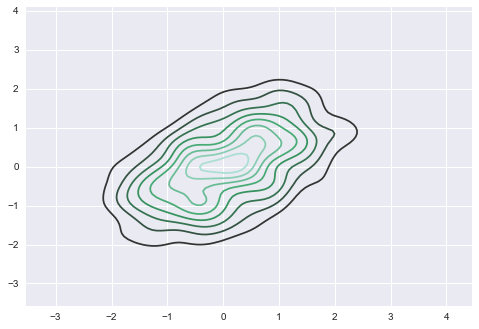

In [18]:
sns.kdeplot(approx.sample(1000)['x'])

Previously we had `trace_cov` function

In [19]:
with model:
    print(pm.trace_cov(trace))

[[ 1.05650289  0.5833865 ]
 [ 0.5833865   1.06457238]]


Now we can estimate the same covariance using `Empirical`

In [20]:
print(approx.cov)

Elemwise{true_div,no_inplace}.0


That's a tensor itself

In [21]:
print(approx.cov.eval())

[[ 1.05544639  0.58280319]
 [ 0.58280319  1.0635078 ]]


Estimations are very close and differ due to precision error. We can get mean in the same way

In [22]:
print(approx.mean.eval())

[-0.01687261  0.00548176]
